# Front Movement Sensitivity

This notebook gives an example calculation and visualisation of detachment front location sensitivity, i.e. how fast will the front move through different regions of the domain depending on the magnetic topology. Front movement is proportional to the fractional B field gradient: the sharper the gradient as a proportion of the B field at that point (see Cowley 2022 for more details). This means the sharper the gradient and the lower the B field, the slower the front movement.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Read and visualise equilibrium
- SPR38 inner and outer, visualised.

<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

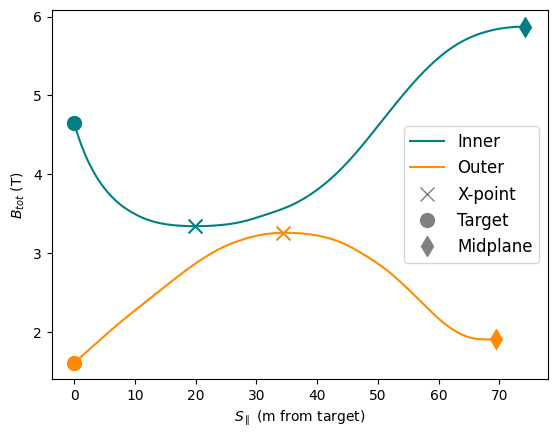

In [2]:
from fusiondls import MagneticGeometry, run_dls
from fusiondls.plot import plot_B_field_profile

spr38 = MagneticGeometry.read_design("eqb_store.pkl", "SPR38")

inner = spr38["iu"]
outer = spr38["ou"]
plot_B_field_profile(
    inner.S, inner.Btot, inner.Xpoint, outer.S, outer.Btot, outer.Xpoint
)

## Run basic density scan on both the inner and the outer

### Set DLS defaults

In [3]:
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr

# set general run parameters
constants = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.02,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbachAr,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

### Run

In [4]:
# Solve at these parallel positions
SparRange = np.linspace(0, outer.S[outer.Xpoint - 1], 5)

results = run_dls(constants, outer, SparRange, control_variable="density")

Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.7 seconds


## Calculate detachment sensitivity

### Function to find detachment band
- The detachment band visualises the extent of the spatial movement of the front in response to a fluctuation.
- The centre of the band is the starting position (arbitrary), while its extents correspond to the positions due to a positive and negative fluctuation in the chosen control variable.
- A lower band is better, because it means the front moves less and is more resistant to fluctuations.

In [5]:
from scipy.interpolate import UnivariateSpline


def make_window_band(d, results, spol_middle, size=0.05):
    """
    Make band based on topology dictionary (d) and results dictionary (o)
    and a desired S poloidal location of the band centre (spol_middle)
    as well as band size as a fraction (default +/-5%)
    """

    crel = results["crel"]
    splot = results["Splot"]
    spolplot = results["SpolPlot"]

    # Need continuous functions for the front locations and corresponding control variables.
    spar_from_crel = UnivariateSpline(crel, splot, k=3)
    spol_from_crel = UnivariateSpline(crel, spolplot, k=3)
    crel_from_spol = UnivariateSpline(spolplot, crel, k=3)

    c_middle = crel_from_spol(spol_middle)

    # Band control variable for middle and both ends.
    control_var = [c_middle * (1 - size), c_middle, c_middle * (1 + size)]

    s_par = spar_from_crel(control_var)
    s_pol = spol_from_crel(control_var)
    index = [np.argmin(np.abs(d.S - s)) for s in s_par]
    Btot_grad = np.gradient(d.Btot)

    return {
        "C": control_var,
        "Spol": s_pol,
        "Spar": s_par,
        "index": index,
        "R": d.R[index],
        "Z": d.Z[index],
        "Btot": d.Btot[index],
        "width_pol": s_pol[2] - s_pol[0],  # Band width in poloidal
        "width_par": s_par[2] - s_par[0],  # Band width in parallel,
        "Btot_avg": np.mean(d.Btot[index[0] : index[2]]),
        "Btot_grad_avg": np.mean(Btot_grad[index[0] : index[2]]),
    }

### Continuous plot of band widths
- Take space between the X-point and the target
- Exclude the lower 10% and upper 20% as regions too close to reattachment or front escape
- Calculate detachment band widths at each point
- Exclude bands whose ends are in the excluded regions near the target or near divertor

Plots:
- LHS: band width. Lower = better = less sensitive front.
- RHS: B field profile. 

Text(0.5, 1.0, 'B field from target to X-point')

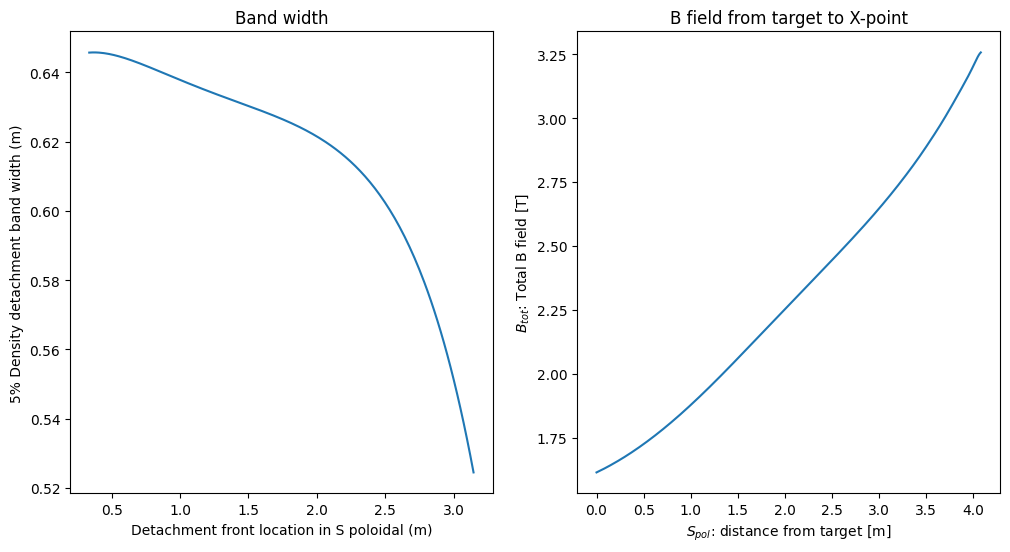

In [6]:
Xpoint = outer.Xpoint
Spolx = outer.Spol[Xpoint]
Spol = outer.Spol

Spol_lims = [Spolx * 0.1, Spolx * 0.8]
widths = []
Btot_avg = []
Btot_grad_avg = []

for s in Spol[:Xpoint]:
    band = make_window_band(outer, results, s)
    if (
        band["Spol"][0] < Spol_lims[0]
        or band["Spol"][2] > Spol_lims[1]
        or band["width_pol"] < 0
    ):
        widths.append(np.nan)
        Btot_avg.append(np.nan)
        Btot_grad_avg.append(np.nan)
    else:
        widths.append(band["width_pol"])
        Btot_avg.append(band["Btot_avg"])
        Btot_grad_avg.append(band["Btot_grad_avg"])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.2)

ax = axes[0]
ax.plot(Spol[:Xpoint], widths)
ax.set_xlabel("Detachment front location in S poloidal (m)")
ax.set_ylabel("5% Density detachment band width (m)")
ax.set_title("Band width")

ax = axes[1]
ax.plot(Spol[:Xpoint], outer.Btot[:Xpoint])
ax.set_xlabel("$S_{pol}$: distance from target [m]")
ax.set_ylabel("$B_{tot}$: Total B field [T]")
ax.set_title("B field from target to X-point")

### Plot of a single band
- Plot a band at a given location (below plot is at 3m).

(0.0, 5.0)

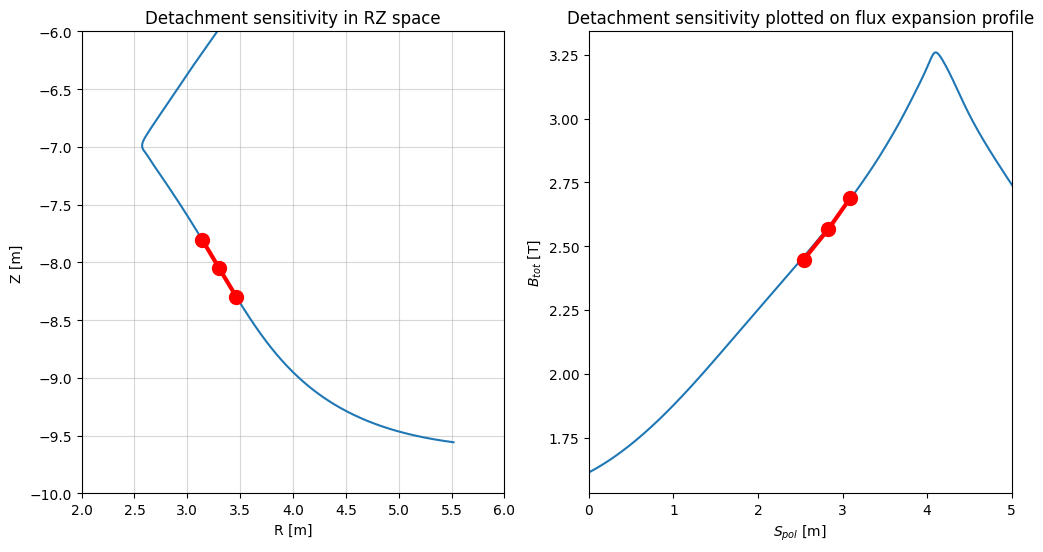

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Make band at 3m
band = make_window_band(outer, results, 3)

ax = axes[0]
ax.plot(outer.R, -outer.Z)
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")
ax.axis((2, 6, -10, -6))
ax.grid(alpha=0.5)
ax.set_title("Detachment sensitivity in RZ space")
ax.plot(band["R"], -band["Z"], markersize=10, marker="o", linewidth=3, color="red")

ax = axes[1]
ax.plot(outer.Spol, outer.Btot)
ax.plot(band["Spol"], band["Btot"], marker="o", color="red", markersize=10, linewidth=3)
ax.set_xlabel(r"$S_{pol}$ [m]")
ax.set_ylabel(r"$B_{tot}$ [T]")
ax.set_title("Detachment sensitivity plotted on flux expansion profile")
ax.set_xlim(0, 5)